In [1]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["font.family"] = "Arial"
sns.set(style='whitegrid')
sns.set_palette("bright")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/ajay/opt/anaconda3/envs/interpretable-ai/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Load Data and EDA

In [52]:
diabetes = load_diabetes()
X, y = diabetes['data'], diabetes['target']
print(diabetes['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [53]:
feature_rename = {'age': 'Age',
                  'sex': 'Sex',
                  'bmi': 'BMI',
                  'bp': 'BP',
                  's1': 'Total Cholesterol',
                  's2': 'LDL',
                  's3': 'HDL',
                  's4': 'Thyroid',
                  's5': 'Glaucoma',
                  's6': 'Glucose'}
df_data = pd.DataFrame(X, 
                       columns=diabetes['feature_names'])
df_data.rename(columns=feature_rename, inplace=True)
df_data['target'] = y

In [54]:
df_data.head()

,Age,Sex,BMI,BP,Total Cholesterol,LDL,HDL,Thyroid,Glaucoma,Glucose,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [5]:
corr = df_data.corr()

In [61]:
len(df_data)

442

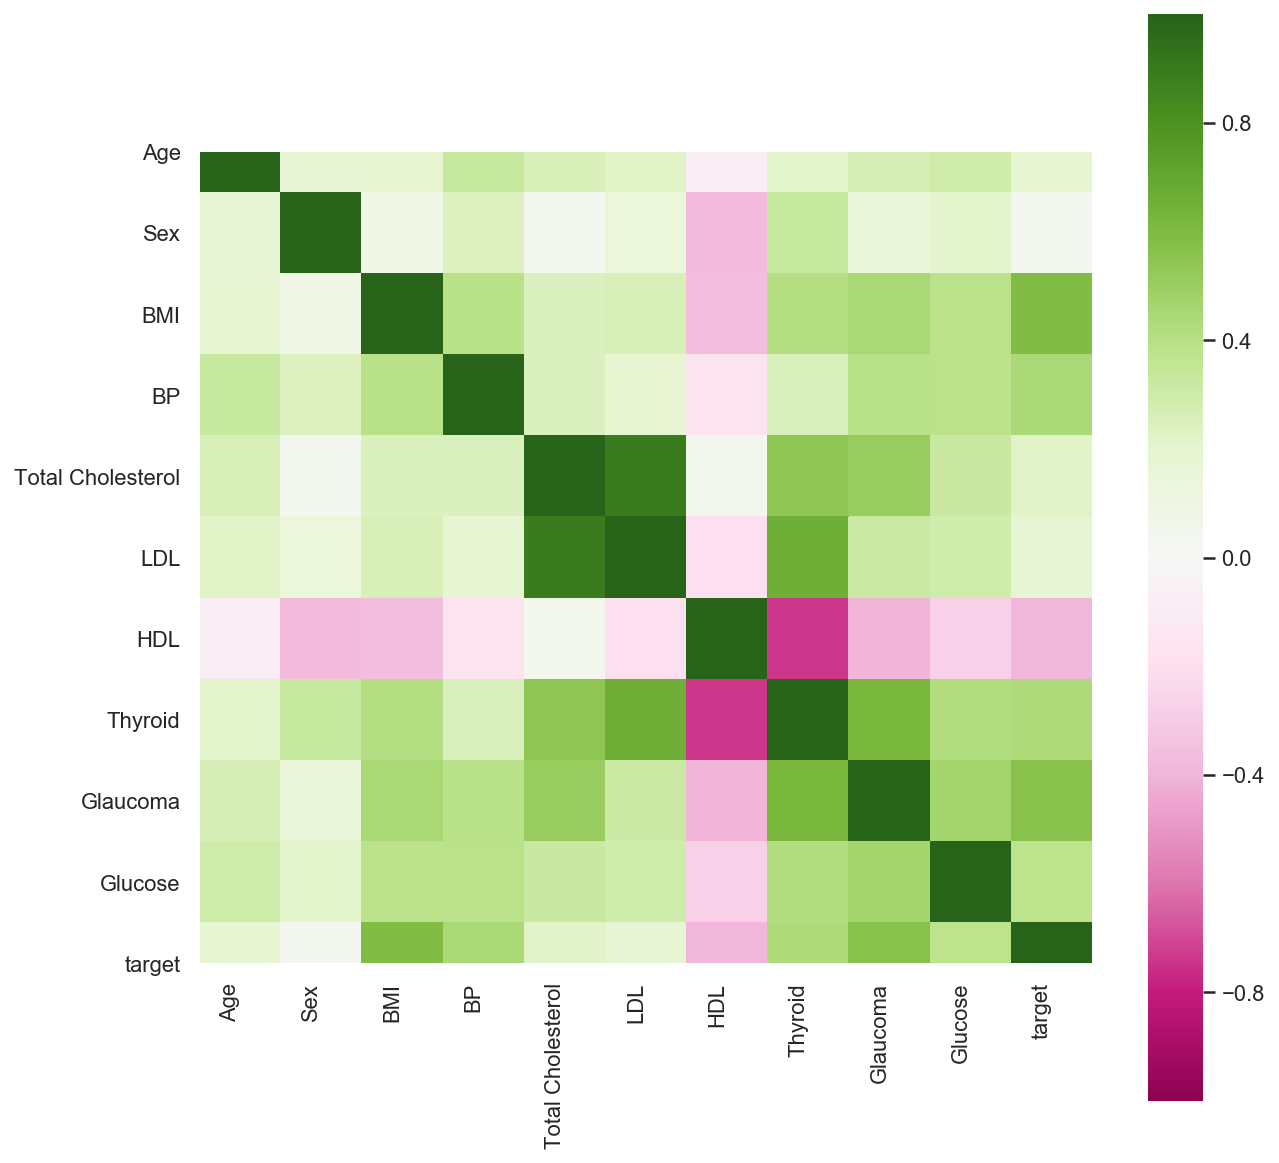

In [6]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap="PiYG",
    square=True,
    ax=ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
f.savefig('images/chapter_02_feature_correlation.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_02_feature_correlation.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Train/Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train.shape

(353, 10)

In [11]:
X_test.shape

(89, 10)

In [12]:
y_train.shape

(353,)

In [13]:
y_test.shape

(89,)

# Train Linear Regression Model

In [14]:
lr_model = LinearRegression()

In [15]:
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Baseline Performance

In [16]:
y_base = np.median(y_test)

In [17]:
mae = np.mean(np.abs(y_test - y_base))
print(mae)

62.21348314606742


In [18]:
rmse = math.sqrt(mean_squared_error(y_test, [y_base for _ in range(len(y_test))]))
print(rmse)

74.69646442605439


In [19]:
mape = np.mean(np.abs(y_test - y_base) / y_test) * 100
print(mape)

51.586778522876116


# Evaluate Linear Regression Model

In [20]:
y_pred = lr_model.predict(X_test)

In [21]:
mae = np.mean(np.abs(y_test - y_pred))
print(mae)

42.793893041965255


In [22]:
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

53.8532569849144


In [23]:
mape = np.mean(np.abs(y_test - y_pred) / y_test) * 100
print(mape)

37.499812530899334


 # Interpret Linear Regression Model

In [24]:
feature_names = diabetes['feature_names']
weights = lr_model.coef_

In [25]:
feature_rename = {'age': 'Age',
                  'sex': 'Sex',
                  'bmi': 'BMI',
                  'bp': 'BP',
                  's1': 'Total Cholesterol',
                  's2': 'LDL',
                  's3': 'HDL',
                  's4': 'Thyroid',
                  's5': 'Glaucoma',
                  's6': 'Glucose'}
feature_names2 = []
for f in feature_names:
    if f not in feature_rename:
        feature_names2.append(f.capitalize())
    else:
        feature_names2.append(feature_rename[f])

In [26]:
weights

array([  37.90031426, -241.96624835,  542.42575342,  347.70830529,
       -931.46126093,  518.04405547,  163.40353476,  275.31003837,
        736.18909839,   48.67112488])

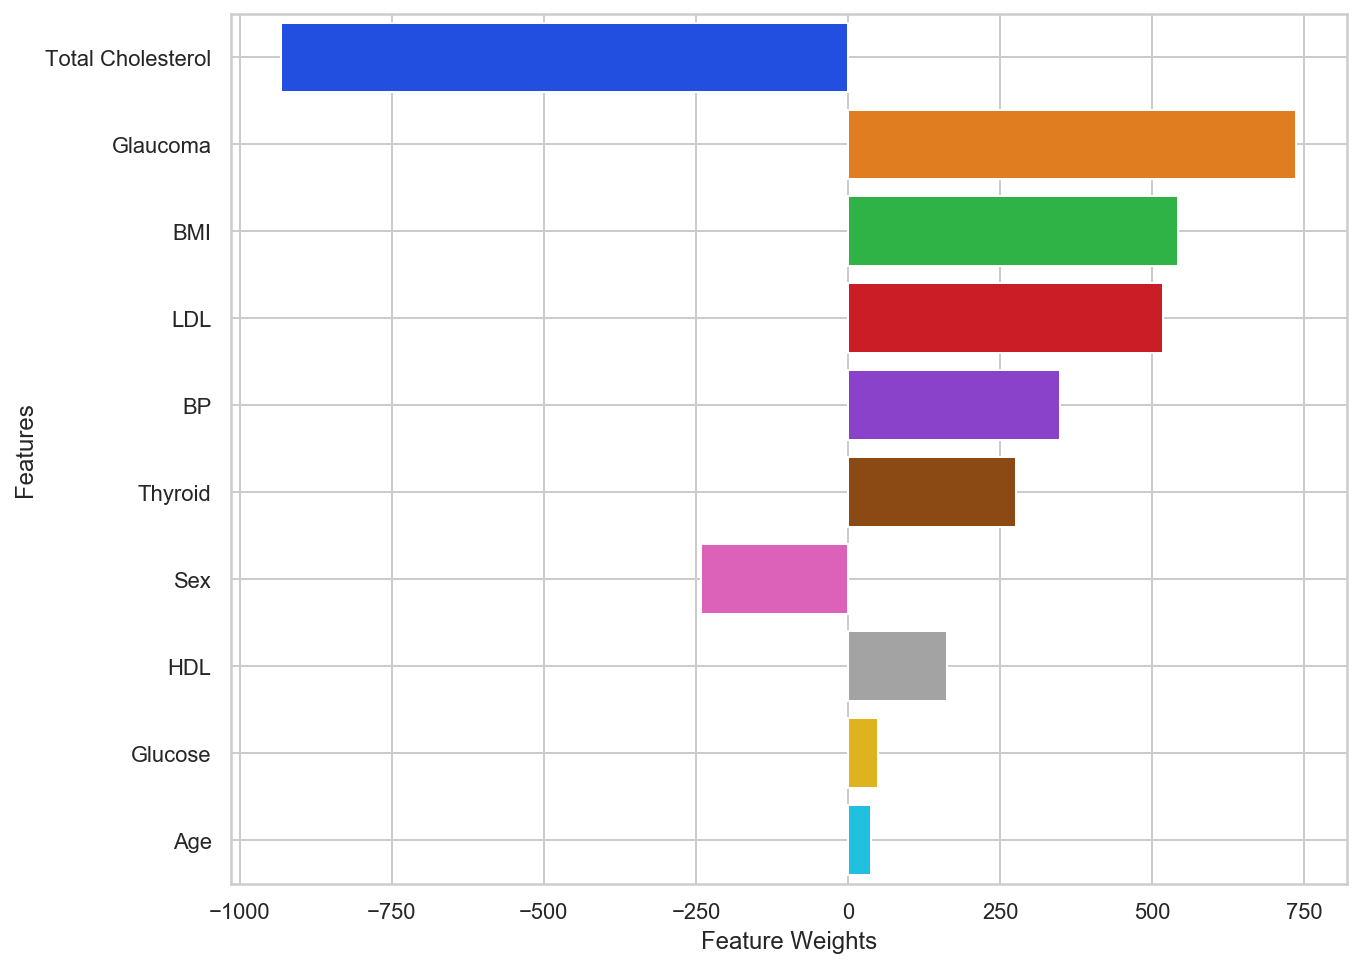

In [28]:
feature_importance_idx = np.argsort(np.abs(weights))[::-1]
feature_importance = [feature_names2[idx] for idx in feature_importance_idx]
feature_importance_values = [weights[idx] for idx in feature_importance_idx]
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=feature_importance_values, y=feature_importance, ax=ax)
ax.grid(True)
ax.set_xlabel('Feature Weights')
ax.set_ylabel('Features')
f.savefig('images/chapter_02_linear_regression_feature_importance.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_02_linear_regression_feature_importance.pdf', format='pdf', dpi=300, bbox_inches='tight');

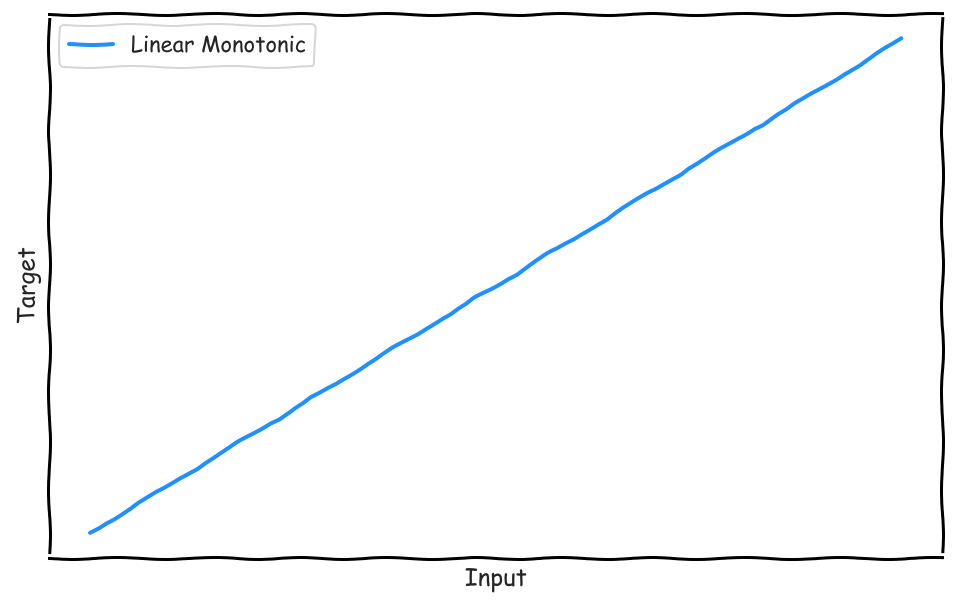

In [30]:
size = 100
input_x = np.arange(0, size)
linear_monotonic_increasing_y = 4 * input_x + np.random.rand(size)
with plt.xkcd():
    f, ax = plt.subplots(figsize=(8, 5))
    ax.plot(input_x, linear_monotonic_increasing_y, 'dodgerblue', label='Linear Monotonic')
    ax.set_xlabel('Input')
    ax.set_ylabel('Target')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend()
    f.savefig('images/chapter_02_linear_response.png', dpi=300, bbox_inches='tight');
    f.savefig('images/chapter_02_linear_response.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Train Decision Tree Model

In [31]:
dt_model = DecisionTreeRegressor(max_depth=None, random_state=42)
dt_model2 = DecisionTreeRegressor(max_depth=3, random_state=42)

In [32]:
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [33]:
dt_model2.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

# Evaluate Decision Tree Model

In [34]:
y_pred = dt_model.predict(X_test)

In [35]:
mae = np.mean(np.abs(y_test - y_pred))
print(mae)

54.764044943820224


In [36]:
y_pred2 = dt_model2.predict(X_test)

In [37]:
mae2 = np.mean(np.abs(y_test - y_pred2))
print(mae2)

48.654477064011274


In [38]:
rmse2 = math.sqrt(mean_squared_error(y_test, y_pred2))
print(rmse2)

60.466411593115076


In [39]:
mape2 = np.mean(np.abs(y_test - y_pred2) / y_test) * 100
print(mape2)

44.397426612519716


# Interpret Decision Tree Model

In [40]:
feature_names = diabetes.feature_names
feature_rename = {'age': 'Age',
                  'sex': 'Sex',
                  'bmi': 'BMI',
                  'bp': 'BP',
                  's1': 'Total Cholesterol',
                  's2': 'LDL',
                  's3': 'HDL',
                  's4': 'Thyroid',
                  's5': 'Glaucoma',
                  's6': 'Glucose'}
feature_names2 = []
for f in feature_names:
    if f not in feature_rename:
        feature_names2.append(f.capitalize())
    else:
        feature_names2.append(feature_rename[f])

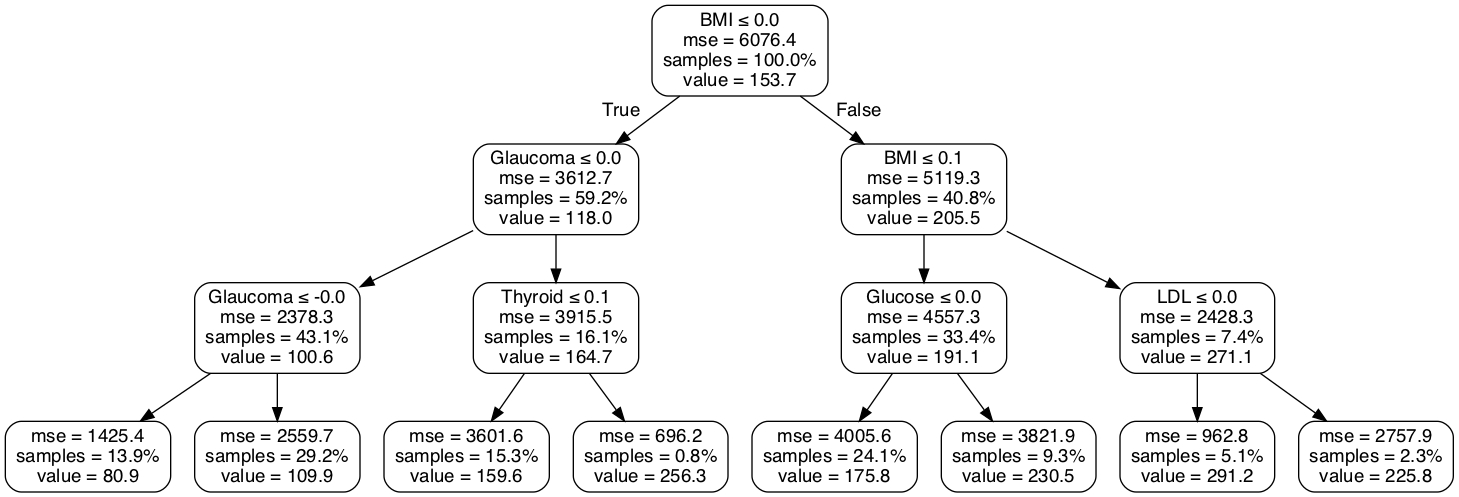

In [50]:
diabetes_dt_dot_data = StringIO()
export_graphviz(dt_model2, 
                out_file=diabetes_dt_dot_data,
                filled=False, rounded=True,
                feature_names=feature_names2,
                proportion=True,
                precision=1,
                special_characters=True)
dt_graph = pydotplus.graph_from_dot_data(diabetes_dt_dot_data.getvalue())  
dt_graph.write_png('images/chapter_02_decision_tree.png')
dt_graph.write_svg('images/chapter_02_decision_tree.svg')
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
drawing = svg2rlg('images/chapter_02_decision_tree.svg')
renderPDF.drawToFile(drawing, 'images/chapter_02_decision_tree.pdf')
Image(dt_graph.create_png())

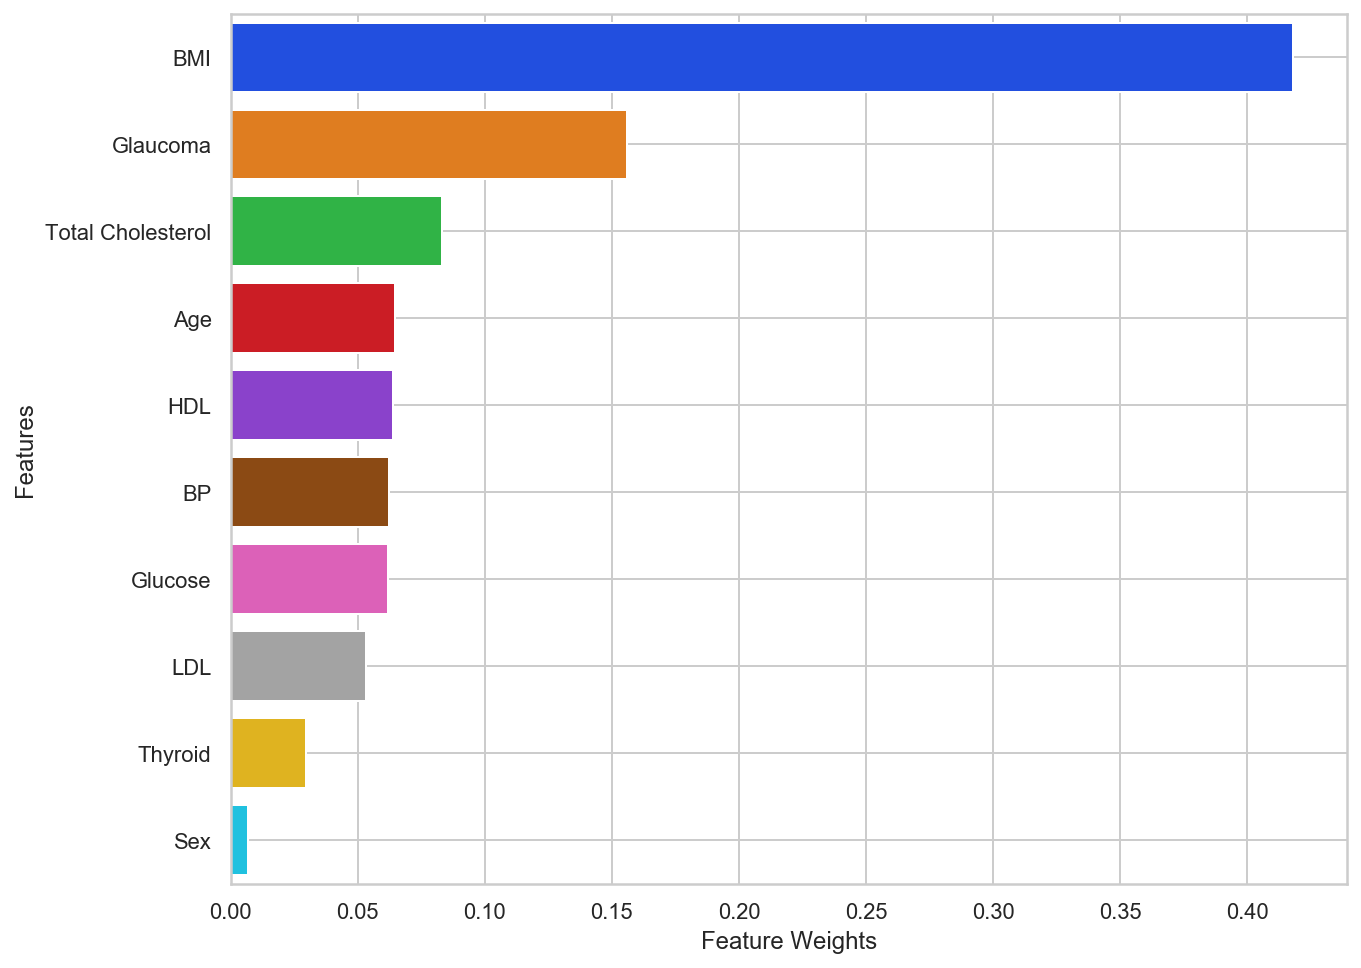

In [43]:
weights = dt_model.feature_importances_
feature_importance_idx = np.argsort(np.abs(weights))[::-1]
feature_importance = [feature_names2[idx] for idx in feature_importance_idx]
feature_importance_values = [weights[idx] for idx in feature_importance_idx]
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=feature_importance_values, y=feature_importance, ax=ax)
ax.grid(True)
ax.set_xlabel('Feature Weights')
ax.set_ylabel('Features')
f.savefig('images/chapter_02_decision_tree_feature_importance.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_02_decision_tree_feature_importance.pdf', format='pdf', dpi=300, bbox_inches='tight');

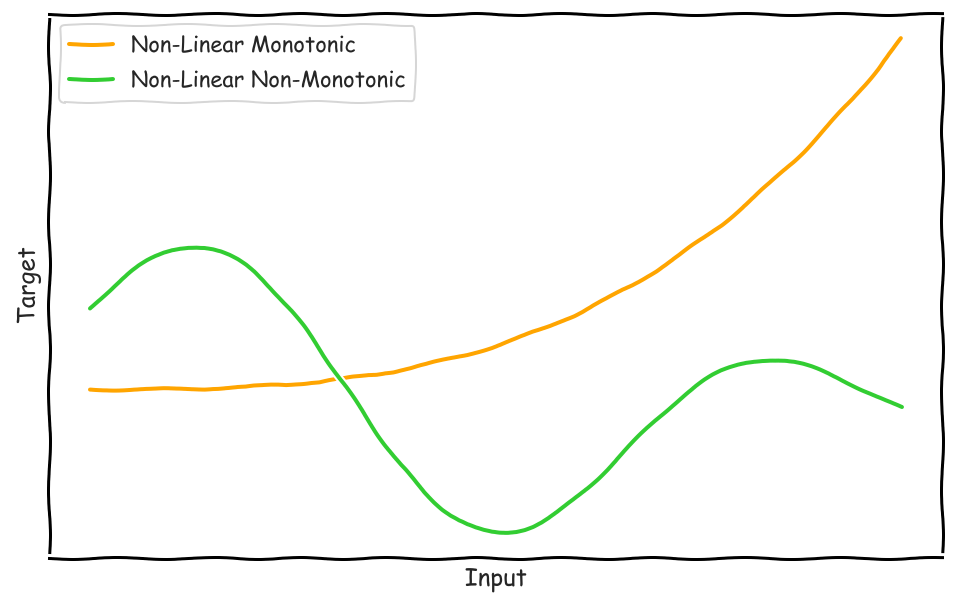

In [44]:
size = 100
input_x = np.arange(0, size)
nonlinear_monotonic_increasing_y = (input_x ** 3) / 1500 + np.random.rand(size) + 500
nonlinear_nonmonotonic_y = (np.cos(input_x/ 20) + np.sin(input_x / 10)) * 150 + 500
with plt.xkcd():
    f, ax = plt.subplots(figsize=(8, 5))
    ax.plot(input_x, nonlinear_monotonic_increasing_y, 'orange', label='Non-Linear Monotonic')
    ax.plot(input_x, nonlinear_nonmonotonic_y, 'limegreen', label='Non-Linear Non-Monotonic')
    ax.set_xlabel('Input')
    ax.set_ylabel('Target')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend()
    f.savefig('images/chapter_02_nonlinear_response.png', dpi=300, bbox_inches='tight');
    f.savefig('images/chapter_02_nonlinear_response.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Underfitting vs Overfitting

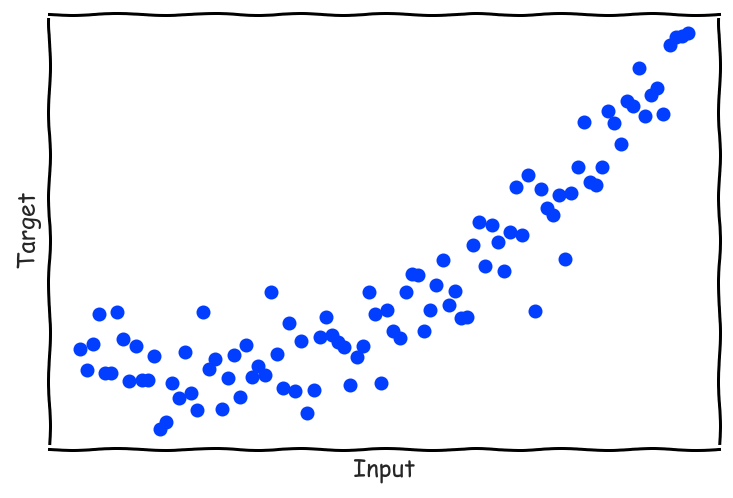

In [45]:
np.random.seed(42)
n_samples = 100

X = np.linspace(0, 10, 100)
rng = np.random.randn(n_samples) * 100

y = 2 * X**0.5 + X ** 3 + rng + 100

# Non-linear data
with plt.xkcd():
    f, ax = plt.subplots()
    ax.scatter(X, y)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Input')
    ax.set_ylabel('Target')
    f.savefig('images/chapter_02_nonlinear_data.png', dpi=300, bbox_inches='tight');
    f.savefig('images/chapter_02_nonlinear_data.pdf', format='pdf', dpi=300, bbox_inches='tight');
#     ax.set_title('Non-Linear Data')

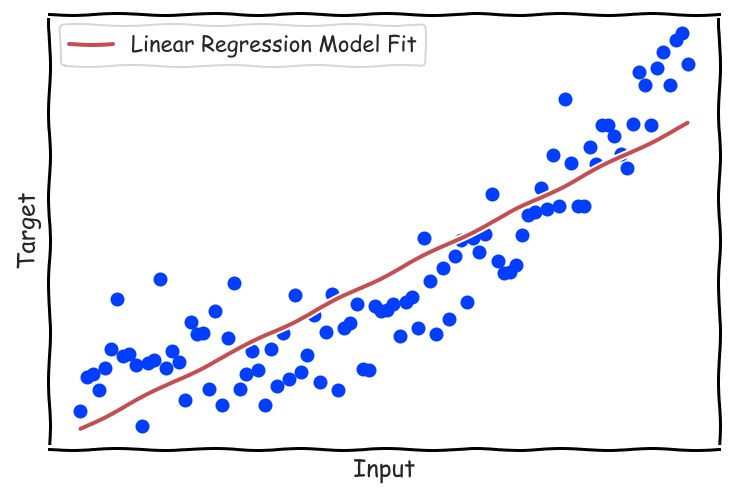

In [46]:
X = np.linspace(0, 10, 100)
rng = np.random.randn(n_samples) * 100

y = 2 * X**0.5 + X ** 3 + rng + 100
lr = LinearRegression()
lr.fit(X.reshape(-1, 1), y)
model_pred = lr.predict(X.reshape(-1,1))
# Underfitting
with plt.xkcd():
    f, ax = plt.subplots()
    ax.scatter(X, y)
    ax.plot(X, model_pred, 'r-', label='Linear Regression Model Fit');
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Input')
    ax.set_ylabel('Target')
    ax.legend()
    f.savefig('images/chapter_02_underfitting.png', dpi=300, bbox_inches='tight');
    f.savefig('images/chapter_02_underfitting.pdf', format='pdf', dpi=300, bbox_inches='tight');

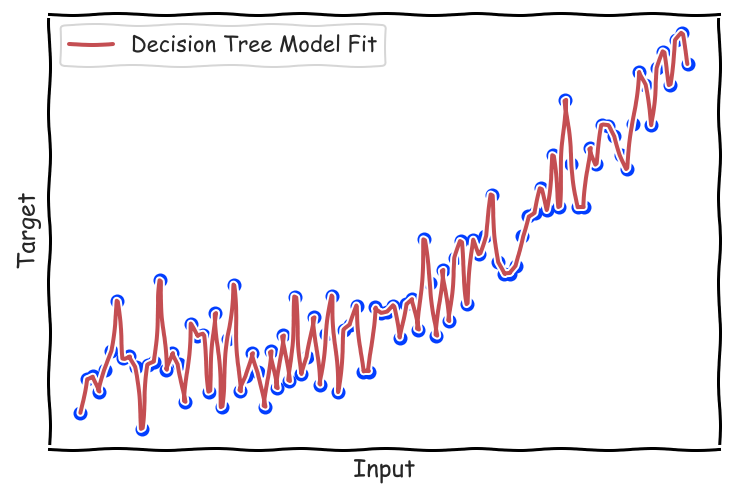

In [47]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X.reshape(-1, 1), y)
model_pred = dt.predict(X.reshape(-1,1))
# Underfitting
with plt.xkcd():
    f, ax = plt.subplots()
    ax.scatter(X, y)
    ax.plot(X, model_pred, 'r-', label='Decision Tree Model Fit');
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Input')
    ax.set_ylabel('Target')
    ax.legend()
    f.savefig('images/chapter_02_overfitting.png', dpi=300, bbox_inches='tight');
    f.savefig('images/chapter_02_overfitting.pdf', format='pdf', dpi=300, bbox_inches='tight');